<class 'numpy.ndarray'>


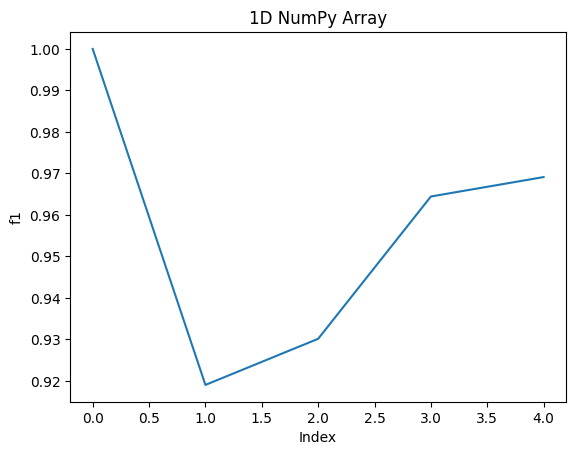

Meilleures configurations :  {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}
Meilleur score : 0.97


In [28]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt


class KNeighborsClassifierCustom:
    def __init__(self, n_neighbors=3, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            distances = self.calculate_distances(x)
            k_nearest_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_indices]
            prediction = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(prediction)
        return np.array(predictions)

    def calculate_distances(self, x):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(self.X_train - x), axis=1)
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

def grid_search_knn(X, y, param_grid, scoring='f1_macro', cv=5):
    best_score = 0
    best_params = {}

    for n_neighbors in param_grid['n_neighbors']:
        for weights in param_grid['weights']:
            for metric in param_grid['metric']:
                knn_model = KNeighborsClassifierCustom(
                    n_neighbors=n_neighbors, weights=weights, metric=metric
                )
                scores = cross_val_score_custom(knn_model, X, y, cv)
                average_score = np.mean(scores)

                if average_score > best_score:
                    best_score = average_score
                    best_params = {
                        'n_neighbors': n_neighbors,
                        'weights': weights,
                        'metric': metric
                    }

    return best_params, best_score

def cross_val_score_custom(model, X, y, cv=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, cv)

    scores = []
    for i in range(cv):
        test_indices = split_indices[i]
        train_indices = np.concatenate([split_indices[j] for j in range(cv) if j != i])
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Assuming classification task, you may replace this with a different scoring metric
        f1_macro = f1_score(y_test, y_pred, average='macro')
        #print(f1_macro)
        scores.append(f1_macro)
        #print(scores)

        #resultat = [elem_1 / elem_2 for elem_1, elem_2 in zip(y_pred, y_test)]
        #print(resultat);
        #print(type(y_pred), len(y_test))

    return np.array(scores)

# Paramètres à explorer
param_grid = {
    'n_neighbors': np.arange(1, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Loading the iris dataset
iris = load_iris()
X = iris['data']
y = iris['target']

# Exécution de la recherche
best_params, best_score = grid_search_knn(X, y, param_grid)

#f1
model = KNeighborsClassifierCustom()
f1 = cross_val_score_custom(model, X, y, cv=5)
print(type(f1))

# Plot the array
plt.plot(f1)
plt.title('1D NumPy Array')
plt.xlabel('Index')
plt.ylabel('f1')
plt.show()

# Affichage des résultats
print('Meilleures configurations : ', best_params)
print('Meilleur score : {:.2f}'.format(best_score))



# Creating the base estimator
base_estimator = KNeighborsClassifierCustom()

 

# Performing the grid search
# grid_search = GridSearchCV(
#     base_estimator,
#     param_grid=parameter_space,
#     scoring="f1_macro",
#     cv=5,
#     n_jobs=-1
# )

# Training the model
#grid_search.fit(X, y)

# # Obtain the best hyperparameters
# best_hyperparameters = grid_search.best_params_
# print("Best Hyperparameters:\n", best_hyperparameters)

# # Get the corresponding F1-score
# best_F1_score = grid_search.best_score_
# print("\nBest F1-Score:", round(best_F1_score, 4))

In [30]:
import numpy as np
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold

class KNeighborsClassifierCustom:
    def __init__(self, n_neighbors=3, weights='uniform', metric='euclidean', window_type='h'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.window_type = window_type
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            distances = self.calculate_distances(x)
            k_nearest_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_indices]

            if self.weights == 'uniform':
                prediction = Counter(k_nearest_labels).most_common(1)[0][0]
            elif self.weights == 'distance':
                epsilon = 1e-10
                weights = 1 / (distances[k_nearest_indices] + epsilon)
                if self.window_type == 'h':
                    weighted_votes = Counter({label: np.sum(weights[k_nearest_labels == label]) for label in np.unique(k_nearest_labels)})
                elif self.window_type == 'k':
                    kernel_weights = self.kernel_function(distances[k_nearest_indices])
                    weighted_votes = Counter({label: np.sum(kernel_weights[k_nearest_labels == label]) for label in np.unique(k_nearest_labels)})
                else:
                    raise ValueError(f"Unsupported window type: {self.window_type}")

                prediction = weighted_votes.most_common(1)[0][0]
            else:
                raise ValueError(f"Unsupported weight type: {self.weights}")

            predictions.append(prediction)

        return np.array(predictions)

    def calculate_distances(self, x):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(self.X_train - x), axis=1)
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

    def kernel_function(self, distances):
        # Example: Triangular kernel
        return np.maximum(1 - distances, 0)

def grid_search_knn(X, y, param_grid, scoring='f1_macro', cv=5):
    best_score = 0
    best_params = {}

    for n_neighbors in param_grid['n_neighbors']:
        for weights in param_grid['weights']:
            for metric in param_grid['metric']:
                for window_type in param_grid['window_type']:
                    knn_model = KNeighborsClassifierCustom(
                        n_neighbors=n_neighbors, weights=weights, metric=metric, window_type=window_type
                    )
                    scores = cross_val_score_custom(knn_model, X, y, cv)
                    average_score = np.mean(scores)

                    if average_score > best_score:
                        best_score = average_score
                        best_params = {
                            'n_neighbors': n_neighbors,
                            'weights': weights,
                            'metric': metric,
                            'window_type': window_type
                        }

    return best_params, best_score

def cross_val_score_custom(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_macro = f1_score(y_test, y_pred, average='macro')
        scores.append(f1_macro)

    return np.array(scores)

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Paramètres à explorer
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'window_type': ['h', 'k']
}

# Exécution de la recherche
best_params, best_score = grid_search_knn(X, y, param_grid)

# Affichage des résultats
print('Meilleures configurations : ', best_params)
print('Meilleur score : {:.2f}'.format(best_score))


AttributeError: 'KNeighborsClassifierCustom' object has no attribute 'predict'